In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

NYC Transit Entrance and Exit Data https://data.ny.gov/Transportation/NYC-Transit-Subway-Entrance-And-Exit-Data/i9wp-a4ja/data
https://data.ny.gov/Transportation/NYC-Transit-Subway-Entrance-And-Exit-Data/i9wp-a4ja

In [2]:
#turnstile = pd.read_csv('./src/NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

In [3]:
def read_mta(file_nums):
    path ='http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
    allFiles = []
    for i in file_nums:
        allFiles.append(path + i + '.txt')
    df_list = [pd.read_csv(file) for file in allFiles]
    df = pd.concat(df_list)
    df.columns = df.columns.str.strip() #Exits Column name has large trailing whitespace
    return df
#get August Data YYMMDD
#Currently mta contains data from September 19, 2020 to April 04, 2020
mta = read_mta(['200919', 
                '200912',
                '200905',
                '200801',
                '200808',
                '200815',
                '200822',
                '200829'])
'''                '200725',
                '200718',
                '200711',
                '200704',
                '200627',
                '200620',
                '200613',
                '200606',
                '200530',
                '200523',
                '200516',
                '200509',
                '200502',
                '200425',
                '200418',
                '200411',
                '200404',
                ])'''

"                '200725',\n                '200718',\n                '200711',\n                '200704',\n                '200627',\n                '200620',\n                '200613',\n                '200606',\n                '200530',\n                '200523',\n                '200516',\n                '200509',\n                '200502',\n                '200425',\n                '200418',\n                '200411',\n                '200404',\n                ])"

In [4]:
mta=mta.reset_index()

In [5]:
mta.head(10)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,00:00:00,REGULAR,7457064,2535856
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,04:00:00,REGULAR,7457067,2535861
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,08:00:00,REGULAR,7457078,2535876
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,REGULAR,7457119,2535920
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,12:00:00,RECOVR AUD,26786,4009
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,16:00:00,REGULAR,7457230,2535953
6,6,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/12/2020,20:00:00,REGULAR,7457355,2535959
7,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,00:00:00,REGULAR,7457420,2535969
8,8,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,04:00:00,REGULAR,7457424,2535972
9,9,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/13/2020,08:00:00,REGULAR,7457431,2535980


In [6]:
#convert to datetime
mta['datetime'] = pd.to_datetime(mta.DATE+' '+mta.TIME)

In [7]:
mta.DESC.value_counts()

REGULAR       1667971
RECOVR AUD       8516
Name: DESC, dtype: int64

In [8]:
#only interested in regular audits. 
mta = pd.DataFrame(mta[mta.DESC == 'REGULAR'])

In [9]:
mta.sort_values(by=['datetime'], inplace=True)
mta.reset_index()

,level_0,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime
0,812841,184544,R510,R090,00-03-01,39 AV,NQW,BMT,07/25/2020,00:00:00,REGULAR,205816,49150,2020-07-25 00:00:00
1,645008,16711,B021,R228,00-05-01,AVENUE J,BQ,BMT,07/25/2020,00:00:00,REGULAR,1941,1052,2020-07-25 00:00:00
2,644965,16668,B021,R228,00-05-00,AVENUE J,BQ,BMT,07/25/2020,00:00:00,REGULAR,535,594,2020-07-25 00:00:00
3,644922,16625,B021,R228,00-04-01,AVENUE J,BQ,BMT,07/25/2020,00:00:00,REGULAR,10,189,2020-07-25 00:00:00
4,644879,16582,B021,R228,00-04-00,AVENUE J,BQ,BMT,07/25/2020,00:00:00,REGULAR,25,17,2020-07-25 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667966,90764,90764,N338,R128,01-05-01,SUTPHIN BLVD,F,IND,09/18/2020,23:58:51,REGULAR,0,927,2020-09-18 23:58:51
1667967,90808,90808,N338,R128,01-06-00,SUTPHIN BLVD,F,IND,09/18/2020,23:58:51,REGULAR,714507,202769,2020-09-18 23:58:51
1667968,90719,90719,N338,R128,01-05-00,SUTPHIN BLVD,F,IND,09/18/2020,23:58:51,REGULAR,1730,0,2020-09-18 23:58:51
1667969,90811,90811,N338,R128,01-06-01,SUTPHIN BLVD,F,IND,09/18/2020,23:58:51,REGULAR,84391956,287312,2020-09-18 23:58:51


In [10]:
#convert ENTRIES and EXITS to number of entries and number of exits between audits
mta['n_in'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES'].diff()
mta['n_out'] = mta.groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS'].diff()

In [11]:
mta.drop(columns=['index'], inplace=True)

In [12]:
#adding n_in and n_out to get total turnstile traffic between audits
mta['turn_traffic'] = mta.n_in + mta.n_out

In [13]:
mta.sample(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic
54690,N063,R011,02-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,09/18/2020,08:00:00,REGULAR,17045,64980,2020-09-18 08:00:00,59.0,118.0,177.0
690134,N095,R014,00-05-00,FULTON ST,ACJZ2345,IND,07/30/2020,13:00:00,REGULAR,15053,0,2020-07-30 13:00:00,0.0,0.0,0.0
1062052,C001,R108,01-00-02,BOROUGH HALL,R2345,BMT,08/14/2020,04:00:00,REGULAR,113968,83237,2020-08-14 04:00:00,1.0,0.0,1.0
283357,N196,R285,00-00-02,FAR ROCKAWAY,A,IND,09/06/2020,08:00:00,REGULAR,2662323,4102987,2020-09-06 08:00:00,49.0,47.0,96.0
1012382,R334,R367,00-05-01,233 ST,25,IRT,08/02/2020,09:00:00,REGULAR,3,1009,2020-08-02 09:00:00,0.0,0.0,0.0


In [14]:
mta.describe()
#n_in and n_out have negative quantities

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,1.667971e+06,1.667971e+06,1.662978e+06,1.662978e+06,1.662978e+06
mean,4.249925e+07,3.492176e+07,4.365484e+02,1.872905e+03,2.309453e+03
std,2.170024e+08,1.980748e+08,3.905581e+06,2.877132e+06,5.746279e+06
min,0.000000e+00,0.000000e+00,-1.879048e+09,-1.813836e+09,-3.051188e+09
25%,2.742605e+05,1.178680e+05,1.000000e+00,2.000000e+00,4.000000e+00
50%,1.775201e+06,1.028635e+06,1.400000e+01,1.600000e+01,4.000000e+01
75%,6.428986e+06,4.285516e+06,5.300000e+01,5.200000e+01,1.170000e+02
max,2.128755e+09,2.123244e+09,1.879048e+09,1.740393e+09,2.371192e+09


In [15]:
#drop negative traffic and assume maximum turns within 4 hours to be 2400 '1 person every 6 seconds'
mask = (mta.n_in >= 0) & (mta.n_out >= 0) & (mta.turn_traffic >= 0) & (mta.n_in < 2400) & (mta.n_out < 2400)
mta = mta[mask]

In [16]:
mta.describe()

,ENTRIES,EXITS,n_in,n_out,turn_traffic
count,1.645440e+06,1.645440e+06,1.645440e+06,1.645440e+06,1.645440e+06
mean,3.123912e+07,2.289574e+07,4.089683e+01,4.262963e+01,8.352647e+01
std,1.750864e+08,1.470429e+08,6.485181e+01,7.253565e+01,1.149575e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.678588e+05,1.151750e+05,1.000000e+00,2.000000e+00,5.000000e+00
50%,1.721841e+06,1.001778e+06,1.500000e+01,1.600000e+01,4.100000e+01
75%,6.223201e+06,4.072400e+06,5.400000e+01,5.200000e+01,1.180000e+02
max,2.128752e+09,2.123214e+09,2.357000e+03,2.365000e+03,4.155000e+03


In [17]:
#n_in and n_out minimum and maximum values are still unreasonable 
#mta.describe()

In [18]:
mta['total_st_traffic'] = mta.groupby('STATION').turn_traffic.transform('sum')

In [19]:
stations_totals = mta[['STATION', 'total_st_traffic']]

In [20]:
stations_totals = stations_totals.drop_duplicates()

In [21]:
stations_totals.sort_values(by='total_st_traffic', ascending=False, inplace=True)

In [22]:
stations_totals[:11]

,STATION,total_st_traffic
766207,34 ST-PENN STA,3148473.0
727801,34 ST-HERALD SQ,2534024.0
774346,125 ST,2404310.0
652309,86 ST,2246130.0
633715,14 ST-UNION SQ,2150461.0
788352,GRD CNTRL-42 ST,2055043.0
681918,42 ST-PORT AUTH,1993993.0
728261,23 ST,1865112.0
820907,FLUSHING-MAIN,1819343.0
723702,FULTON ST,1747045.0


Text(0.5, 0, 'Total Traffic')

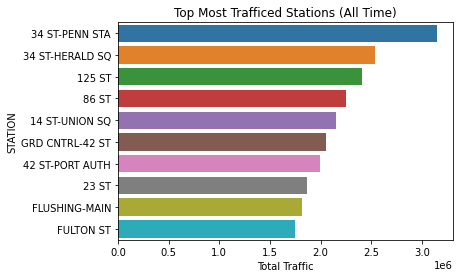

In [23]:
sns.barplot(x='total_st_traffic', y='STATION', data=stations_totals[:10])
plt.title('Top Most Trafficed Stations (All Time)')
plt.xlabel('Total Traffic')

In [24]:
#Assume focus on top ten total traffic
s = [each for _, each in stations_totals[:10]['STATION'].items()]

In [25]:
top_ten_df = pd.DataFrame(mta[mta.STATION.isin(s)])

In [26]:
top_ten_df.STATION.value_counts()

34 ST-PENN STA     32603
FULTON ST          32066
GRD CNTRL-42 ST    24073
23 ST              23934
86 ST              21351
34 ST-HERALD SQ    17376
42 ST-PORT AUTH    15779
125 ST             14014
14 ST-UNION SQ     13770
FLUSHING-MAIN       8324
Name: STATION, dtype: int64

In [27]:
top_ten_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,total_st_traffic
788352,R238A,R046,02-03-01,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,2883508,384997,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0
788268,R238A,R046,02-00-04,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,4303565,443201,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0
788310,R238A,R046,02-03-00,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,842671,28043,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0
728261,N509,R203,00-00-00,23 ST,FM,IND,07/25/2020,04:00:00,REGULAR,5565,13530,2020-07-25 04:00:00,0.0,5.0,5.0,1865112.0
787974,R238,R046,00-07-01,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,6530,218841,2020-07-25 04:00:00,1.0,6.0,7.0,2055043.0


In [28]:
top_ten_df['day_of_week'] = top_ten_df['datetime'].apply(lambda x : x.weekday())

In [29]:
#or take the mean?
top_ten_df['daily_traffic'] = top_ten_df.groupby(['STATION', 'day_of_week']).turn_traffic.transform('sum')
#Gives cumulative traffic by day of week

In [30]:
daily_df = pd.DataFrame(top_ten_df[['STATION', 'day_of_week', 'daily_traffic']])

In [31]:
daily_df.drop_duplicates(inplace=True)

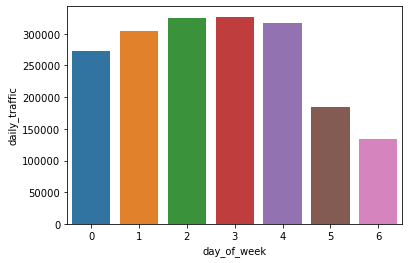

In [32]:
sns.barplot(x='day_of_week', y='daily_traffic', data=daily_df[daily_df.STATION=='23 ST'])

In [33]:
top_ten_df['traffic_by_time_by_station'] = top_ten_df.groupby(['STATION', 'day_of_week', 'TIME']).turn_traffic.transform('sum')

In [34]:
top_ten_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,datetime,n_in,n_out,turn_traffic,total_st_traffic,day_of_week,daily_traffic,traffic_by_time_by_station
788352,R238A,R046,02-03-01,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,2883508,384997,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0,5,177194.0,2082.0
788268,R238A,R046,02-00-04,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,4303565,443201,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0,5,177194.0,2082.0
788310,R238A,R046,02-03-00,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,842671,28043,2020-07-25 04:00:00,0.0,0.0,0.0,2055043.0,5,177194.0,2082.0
728261,N509,R203,00-00-00,23 ST,FM,IND,07/25/2020,04:00:00,REGULAR,5565,13530,2020-07-25 04:00:00,0.0,5.0,5.0,1865112.0,5,184066.0,1968.0
787974,R238,R046,00-07-01,GRD CNTRL-42 ST,4567S,IRT,07/25/2020,04:00:00,REGULAR,6530,218841,2020-07-25 04:00:00,1.0,6.0,7.0,2055043.0,5,177194.0,2082.0


In [35]:
top_ten_df['d_traffic'] = top_ten_df.groupby(['STATION', 'DATE']).turn_traffic.transform('sum')

In [41]:
top_ten_df['mean_d_traffic'] = top_ten_df.groupby(['STATION','day_of_week']).d_traffic.transform('mean')

In [42]:
df = pd.DataFrame(top_ten_df[['STATION', 'day_of_week', 'mean_d_traffic']])

In [43]:
df.drop_duplicates(inplace=True)

<Figure size 432x288 with 0 Axes>

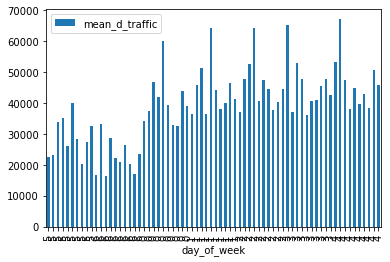

In [45]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
plt.figure()

df.plot.bar(x='day_of_week', y='mean_d_traffic', stacked=True)

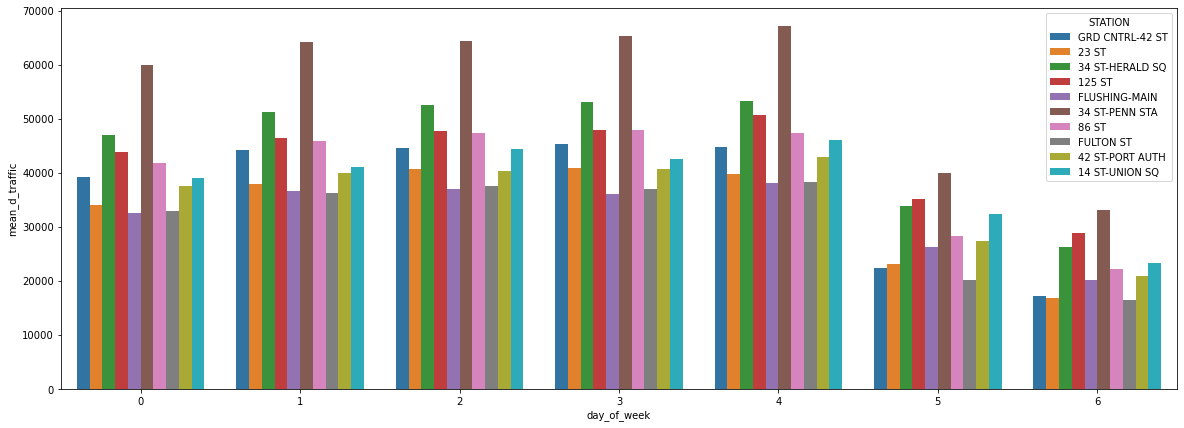

In [44]:
plt.figure(figsize=[20,7])
sns.barplot(x='day_of_week', y='mean_d_traffic', hue='STATION', data=df)

In [64]:
pivot_df = df.pivot(index='day_of_week', columns='STATION', values='mean_d_traffic')
pivot_df

STATION,125 ST,14 ST-UNION SQ,23 ST,34 ST-HERALD SQ,34 ST-PENN STA,42 ST-PORT AUTH,86 ST,FLUSHING-MAIN,FULTON ST,GRD CNTRL-42 ST
day_of_week,,,,,,,,,,
0,43921.467839,39000.694501,34116.805077,46919.698304,59949.654943,37521.893103,41873.999020,32608.077320,32922.530306,39252.727455
1,46430.917331,41148.420408,38001.363427,51306.701600,64139.070914,39949.299828,45885.606946,36527.149485,36282.496411,44288.065502
2,47714.601294,44459.979713,40647.502910,52570.104861,64285.551089,40388.764680,47390.113288,37037.164948,37629.333985,44615.949460
3,47926.883143,42610.709710,40835.461561,53077.268000,65348.991620,40756.005025,47832.272934,36002.428073,37056.024824,45378.545113
4,50614.336648,45976.622496,39772.933373,53261.689683,67056.488170,42960.347965,47376.949147,38142.604960,38333.506626,44746.668320
5,35160.731683,32425.145651,23084.192285,33921.241677,39914.347711,27432.157156,28304.179946,26216.474852,20145.129247,22391.475148
6,28801.852941,23330.625000,16830.942924,26255.319662,33113.562891,20863.921270,22185.870020,20131.380399,16471.654829,17125.335449


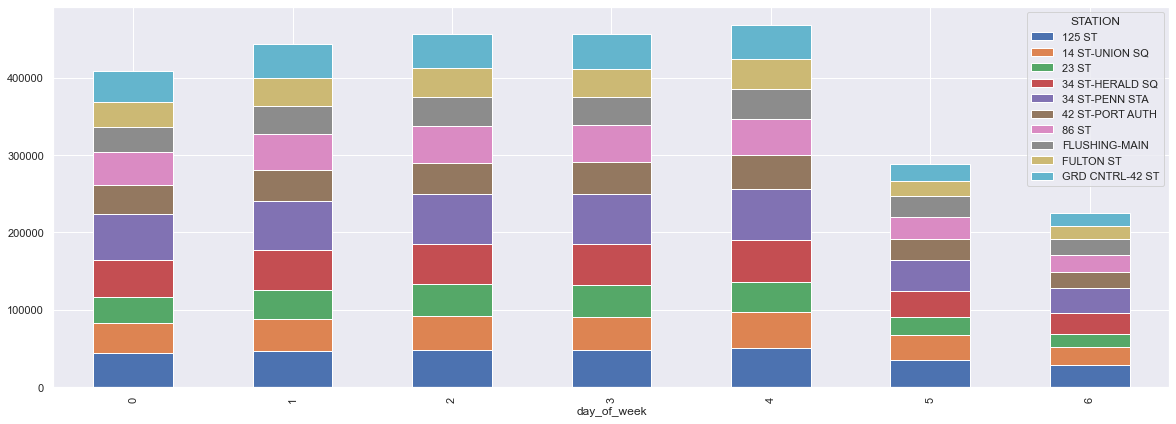

In [72]:
pivot_df.plot.bar(stacked=True, figsize=(20,7))
